In [58]:
import xml.etree.ElementTree as ET # for parsing XML
import random # random sampling
import matplotlib.pyplot as plt # plotting
from tqdm.auto import tqdm # progress bar
import seaborn as sns # plotting
import spacy # NLP

sns.set(context='paper', style='ticks', font_scale=1) # set the plot style

Function to extact bibles from the [Bible corpus](https://github.com/christos-c/bible-corpus):

In [59]:
def get_bible(lang):
    '''
    Takes the language of the Bible as input and writes the text of the Bible to a text file.
    '''
    root = ET.fromstring(open(f'bible-corpus-v.1.13.1/bibles/{lang}.xml').read())
    with open(f'{lang}.txt', 'w', encoding='utf-8') as out:
        for n in root.iter('seg'):
            out.write(n.text.strip() + '\n')


# get_bible('English')
# get_bible('Russian')
# get_bible('German')
# get_bible('French')

Installing the necessary models for spacy:

In [60]:
# !python -m spacy download ru_core_news_sm
# !python -m spacy download en_core_web_sm
# !python -m spacy download de_core_news_sm
# !python -m spacy download fr_core_news_sm

## 1. Introduction to spacy

[Spacy](https://spacy.io/) is a Python library for Natural Language Processing (NLP) that is designed to be fast and easy to use. It is a powerful, production-ready library that can be used for a wide range of NLP tasks, such as named entity recognition, part-of-speech tagging, and dependency parsing. We will be using spacy mainly to perform **morphological analysis** on the text data. In several languages. 

You start by initiating your model for a specific language. In this case, we will be using the French model, that we installed previosly:

In [61]:
nlp_fr = spacy.load("fr_core_news_sm")

Let's start by analyzing a simple sentence in French:

In [62]:
for t in nlp_fr("J'ai achete trois chats."):
    print(f'Word-form: {t.text}, Lemma: {t.lemma_}, POS: {t.pos_}')

Word-form: J', Lemma: je, POS: PRON
Word-form: ai, Lemma: avoir, POS: AUX
Word-form: achete, Lemma: achete, POS: VERB
Word-form: trois, Lemma: trois, POS: NUM
Word-form: chats, Lemma: chat, POS: NOUN
Word-form: ., Lemma: ., POS: PUNCT


You can see that the spacy package can lemmatize the words, and also provide the part of speech of each word. However, we would like to get the morphological analysis of the words in the sentence as well. Let's do that:

In [63]:
for t in nlp_fr("J'ai achete trois chats."):
    print(f'Word-form: {t.text}, Lemma: {t.lemma_}, Morph: {t.morph}')

Word-form: J', Lemma: je, Morph: Number=Sing|Person=1
Word-form: ai, Lemma: avoir, Morph: Mood=Ind|Number=Sing|Person=1|Tense=Pres|VerbForm=Fin
Word-form: achete, Lemma: achete, Morph: Mood=Ind|Person=3|VerbForm=Fin
Word-form: trois, Lemma: trois, Morph: NumType=Card
Word-form: chats, Lemma: chat, Morph: Gender=Masc|Number=Plur
Word-form: ., Lemma: ., Morph: 


Unfortunately, it does not provide morphemic analysis, but it does provide the morphological features like number for nouns, or tense for verbs. 

Let's convert this into a function and look at other sentences as well:

In [64]:
def morp_analyze(text):
    return [(t.text, t.lemma_, t.pos_, t.morph) for t in nlp_fr(text)]

Let' see how it works with a sentence with some complex tense:

In [65]:
morp_analyze("J’avais fini de manger mon dessert quand mon père rentra du travail.")

[('J’', 'J’', 'PROPN', ),
 ('avais', 'avai', 'ADJ', Gender=Masc),
 ('fini', 'finir', 'VERB', Gender=Masc|Number=Sing|Tense=Past|VerbForm=Part),
 ('de', 'de', 'ADP', ),
 ('manger', 'manger', 'VERB', VerbForm=Inf),
 ('mon', 'mon', 'DET', Number=Sing|Poss=Yes),
 ('dessert', 'dessert', 'PROPN', Gender=Masc|Number=Sing),
 ('quand', 'quand', 'SCONJ', ),
 ('mon', 'mon', 'DET', Number=Sing|Poss=Yes),
 ('père', 'père', 'NOUN', Gender=Masc|Number=Sing),
 ('rentra',
  'rentrer',
  'VERB',
  Mood=Ind|Number=Sing|Person=3|Tense=Fut|VerbForm=Fin),
 ('du', 'de', 'ADP', Definite=Def|Gender=Masc|Number=Sing|PronType=Art),
 ('travail', 'travail', 'NOUN', Gender=Masc|Number=Sing),
 ('.', '.', 'PUNCT', )]

You can see that we can learn a great deal about the morphological features of the words in the sentence, meaning that we can use this information to measure morphological complexity of a particular language.

## 2. Morphological complexity of function vs. content words

During our class, we discussed that function words are usually less morphologically complex than content words. We can use the spacy package to measure the morphological complexity of function and content words in a sentence. Let's see how we can do that.

First, we will need to define a list of fuction POS tags. We can use the following list of POS tags to define function words:

In [66]:
function_tags = ['DET', 'ADP', 'AUX', 'CCONJ', 'SCONJ', 'PRON', 'PART']

The same for content words:

In [67]:
content_tags = ['NOUN', 'VERB', 'ADJ', 'ADV']

But we also need a text -- let's use the Bible in French:

In [87]:
french_bible = open('French.txt', 'r', encoding='utf-8').read().split('\n')

Let's print a couple of sentences from the Bible to see how it looks like:

In [69]:
french_bible[:10]

['Au commencement, Dieu créa les cieux et la terre.',
 'La terre était informe et vide: il y avait des ténèbres à la surface de l`abîme, et l`esprit de Dieu se mouvait au-dessus des eaux.',
 'Dieu dit: Que la lumière soit! Et la lumière fut.',
 'Dieu vit que la lumière était bonne; et Dieu sépara la lumière d`avec les ténèbres.',
 'Dieu appela la lumière jour, et il appela les ténèbres nuit. Ainsi, il y eut un soir, et il y eut un matin: ce fut le premier jour.',
 'Dieu dit: Qu`il y ait une étendue entre les eaux, et qu`elle sépare les eaux d`avec les eaux.',
 'Et Dieu fit l`étendue, et il sépara les eaux qui sont au-dessous de l`étendue d`avec les eaux qui sont au-dessus de l`étendue. Et cela fut ainsi.',
 'Dieu appela l`étendue ciel. Ainsi, il y eut un soir, et il y eut un matin: ce fut le second jour.',
 'Dieu dit: Que les eaux qui sont au-dessous du ciel se rassemblent en un seul lieu, et que le sec paraisse. Et cela fut ainsi.',
 'Dieu appela le sec terre, et il appela l`amas des 

Let's analyze each of these sentences, and count the morphological tags per word in content and function words:

In [70]:
cont_tags = []
func_tags = []

for line in tqdm(french_bible[:1000]):
    for t in nlp_fr(line):
        if t.pos_ in content_tags:
            cont_tags.append(len(t.morph))
        if t.pos_ in function_tags:
            func_tags.append(len(t.morph))

100%|██████████| 1000/1000 [00:06<00:00, 148.96it/s]


In [71]:
print(f'Average number of morphemes in content words: {sum(cont_tags) / len(cont_tags)}')
print(f'Average number of morphemes in function words: {sum(func_tags) / len(func_tags)}')

Average number of morphemes in content words: 2.389647735442128
Average number of morphemes in function words: 1.7815141492098494


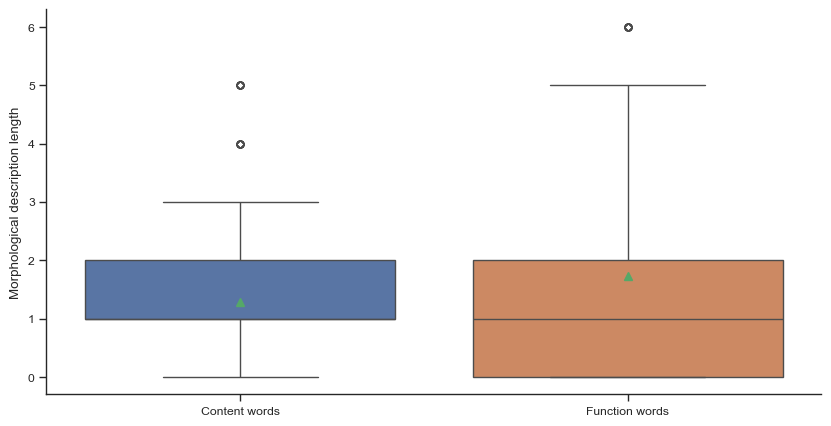

In [84]:
plt.figure(figsize=(10, 5))
# sns.pointplot(data=[cont_tags, func_tags], errorbar=("ci", 95), linestyle='none')
sns.boxplot(data=[cont_tags, func_tags], showmeans=True)
plt.xticks([0, 1], ['Content words', 'Function words'])
plt.ylabel('Morphological description length')
sns.despine()
plt.show()

Let's look at English as well:

In [73]:
english_bible = open('English.txt', 'r', encoding='utf-8').read().split('\n')

nlp_en = spacy.load("en_core_web_sm")

cont_tags = []
func_tags = []

for line in tqdm(english_bible[:1000]):
    for t in nlp_en(line):
        if t.pos_ in content_tags:
            cont_tags.append(len(t.morph))
        if t.pos_ in function_tags:
            func_tags.append(len(t.morph))

100%|██████████| 1000/1000 [00:06<00:00, 152.24it/s]


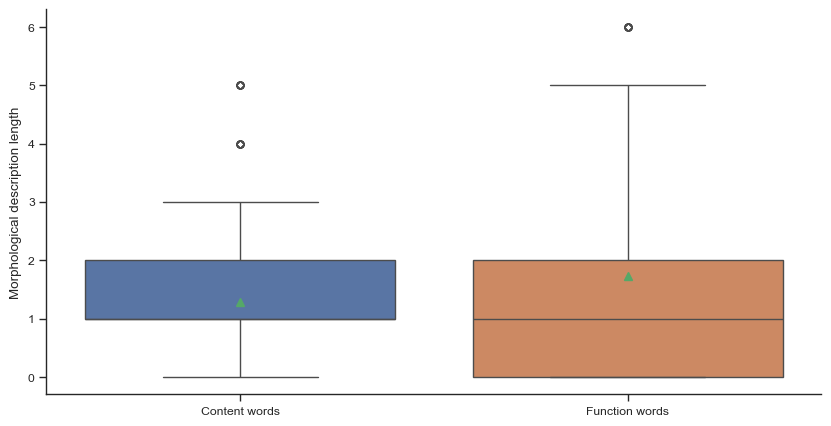

In [83]:
plt.figure(figsize=(10, 5))
# sns.pointplot(data=[cont_tags, func_tags], errorbar=("ci", 95), linestyle='none')
sns.boxplot(data=[cont_tags, func_tags], showmeans=True)
plt.xticks([0, 1], ['Content words', 'Function words'])
plt.ylabel('Morphological description length')
sns.despine()
plt.show()

## 3. Morpheme to word ratio

Finally, we can use the morphological features to approximate the morpheme to word ratio in a sentence. We can do this by counting the number of morphological features and dividing it by the number of words in the sentence. Let's see how we can do that. First, we will do it for French:

In [75]:
num_morph = 0
num_words = 0

for sentence in french_bible[:1000]:
    doc = nlp_fr(sentence)
    for token in doc:
        num_morph += len(token.morph)
        num_words += 1

Let's see what we get:

In [76]:
print(f'Average number of morphological features per word in French: {num_morph / num_words}')

Average number of morphological features per word in French: 1.647645739910314


How can we be sure that we are getting the valid ratio. Let's sample 100, 200, 500 and 1000 random sentences from the Bible and calculate the morphological features to word ratio for each of these samples. We can then plot the distribution of the morpheme to word ratio for each of these samples. Let's do that:

In [77]:
ratios = []

for _ in range(5):  # Repeat 5 times
    ratio_sentences = []
    for size in tqdm([100, 200, 500, 1000]):
        num_morph = 0
        num_words = 0
        for sentence in random.sample(english_bible, size):
            doc = nlp_en(sentence)
            for token in doc:
                num_morph += len(token.morph)
                num_words += 1
        ratio_sentences.append(num_morph / num_words)
    ratios.append(ratio_sentences)

100%|██████████| 4/4 [00:11<00:00,  2.85s/it]


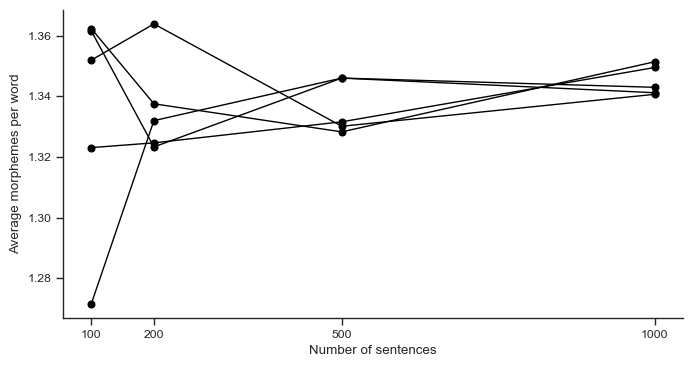

In [82]:
plt.figure(figsize=(8, 4))
for ratio in ratios:
    plt.plot([100, 200, 500, 1000], ratio, 
             marker='o', color='black', 
             linestyle='-', linewidth=1)
plt.xlabel('Number of sentences')
plt.ylabel('Average morphemes per word')
plt.xticks([100, 200, 500, 1000])
sns.despine()
plt.show()

As we can see, the ratio is quite stable when 1000 sentences are sampled, so we can use such a small sample to estimate this ratio. What happends when you sample 5000 sentences?

In [88]:
### YOUR CODE HERE ###

Let's compute this ratio for German now:

In [79]:
german_bible = open('German.txt', 'r', encoding='utf-8').read().split('\n')

nlp_de = spacy.load("de_core_news_sm")

Let's also write the function to calculate the morpheme to word ratio for a given language:

In [80]:
def morp_ratio(bible, nlp):
    num_morph = 0
    num_words = 0
    for sentence in bible[:1000]:
        doc = nlp(sentence)
        for token in doc:
            num_morph += len(token.morph)
            num_words += 1
    return num_morph / num_words

The ratio for German:

In [81]:
morp_ratio(german_bible, nlp_de)

2.3723136267023537

Now, you can try the same thing for other languages, like Russian or German. Does this number match with their morphological type?

In [85]:
### YOUR CODE HERE ###